<a href="https://colab.research.google.com/github/scaomath/wustl-math450/blob/main/Lectures/Math_450_Notebook_3_(Matrix_Vector_multiplication).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding Lecture 2

Overall goal of the our class:
- learn how to check and profile the machine learning code written in PyTorch.
  - Write torch-like code from scratch.
  - Write our own optimizer.
  - (advanced) config a debugger in VsCode to monitor the performance.

Today's goal:
- Use matrix vector multiplication in `torch`.
- Iterations to prepare the implementation of a simple gradient descent algorithm.

This is a worksheet version of the notebook. We can follow along during the coding lecture and then download the annotated version on the Canvas.

Reference:
- Numpy's neural network implementation from scratch: https://www.kaggle.com/scaomath/simple-mnist-numpy-from-scratch

In [1]:
import numpy as np
import torch

In [9]:
# build a tensor
x = torch.Tensor([0.5, 0.8])
print(x[0].item())
x = torch.arange(8)
print(x)
A = torch.eye(3)
print(A)
x = torch.randn((3, 2))
print(x)

0.5
tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[-1.7303,  0.2998],
        [-1.4725, -0.6713],
        [-0.6057,  0.0626]])


In [10]:
# polymorphism in Python is inherited in PyTorch
sum([0, 1, 3])

4

In [12]:
np.sum(torch.arange(8))

TypeError: ignored

In [14]:
x = torch.arange(8)
print(x.sum())
y = np.arange(8)
print(y.sum())

tensor(28)
28


### Matrix vector multiplication
- `dot` and `mm` in `torch`
- `*` is something different (elementwise multiplication)

In [15]:
# example
?torch.matmul

In [16]:
A = torch.randn(2, 20)
x = torch.randn(20)
print(torch.matmul(A, x))

tensor([-3.8048,  3.8471])


In [18]:
print(A.mm(x))

RuntimeError: ignored

In [51]:
a = torch.arange(8)
print(a*a) # same behavior with .* in MATLAB

tensor([ 0,  1,  4,  9, 16, 25, 36, 49])


### Manipulating the axis

- `None`
- `size()` and `shape`
- `squeeze` and `unsqueeze()`

In [22]:
t = torch.Tensor([1,2,3])
print(t)
print(t.shape)
print(t[:, None])
print(t[:, None].shape)


tensor([1., 2., 3.])
torch.Size([3])
tensor([[1.],
        [2.],
        [3.]])
torch.Size([3, 1])


In [24]:
A.mm(x[:, None])

tensor([[-3.8048],
        [ 3.8471]])

In [26]:
print(x)
print(x.shape)

tensor([ 0.5016,  0.6650, -0.6638, -0.3924, -1.2450, -0.9226, -0.8810, -0.4183,
        -0.1716, -0.3601, -1.0147,  0.6471,  0.2267,  0.1683,  0.5801, -0.4954,
        -1.2984, -1.7405,  1.1541, -0.5423])
torch.Size([20])


In [28]:
print(x.unsqueeze(dim=0))
print(x.unsqueeze(0).shape)
print(x.unsqueeze(-1).shape)

tensor([[ 0.5016,  0.6650, -0.6638, -0.3924, -1.2450, -0.9226, -0.8810, -0.4183,
         -0.1716, -0.3601, -1.0147,  0.6471,  0.2267,  0.1683,  0.5801, -0.4954,
         -1.2984, -1.7405,  1.1541, -0.5423]])
torch.Size([1, 20])
torch.Size([20, 1])


## Reproducibility
Fixing the random number generation seed.

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [37]:
torch.manual_seed(2)
# in cell mode (not a single .py file), we have to put
# torch.manual_seed(SEED) in each cell we want reproducibility
torch.randn((5,))

tensor([ 0.3923, -0.2236, -0.3195, -1.2050,  1.0445])

In [38]:
dtype = torch.float # single-precision float number
device = torch.device("cpu")

# if GPU is to be used
# first go to Runtime->Runtime type->Select GPU as accelerator
# then uncomment this to run on GPU
# device = torch.device("cuda:0")

In [39]:
# N is the sample size (or current mini-batch size);
# D_in is input dimension;
# N_H is hidden dimension
N, D_in, N_H = 1, 10, 5

In [40]:
# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
# x: sample, is a row vector, each row represents a sample
torch.manual_seed(42)
x = torch.randn(N, D_in, device=device, dtype=dtype)
print(x)

tensor([[ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
          0.4617,  0.2674]])


In [41]:
# why using row as sample?
X = torch.randn((5, 7)) # 5 samples, 7 features (input_dim)
print(X)

tensor([[-0.7581,  1.0783,  0.8008,  1.6806,  0.3559, -0.6866, -0.4934],
        [ 0.2415, -0.2316,  0.0418, -0.2516,  0.8599, -0.3097, -0.3957],
        [ 0.8034, -0.6216,  0.3189, -0.4245,  0.3057, -0.7360, -0.8371],
        [-0.9224,  1.8113,  0.1606,  0.3672,  0.1754,  1.3852,  1.3835],
        [-1.2024,  0.7078, -1.0759,  0.5357,  1.1754,  0.5612, -0.4527]])


In [45]:
# row corresponds to axis 0
print(X[3]) # returns row 3 (the 4th row), single index, handy
print(X[3, :])
print(X[:, 1]) # column 1 (not convenient to track column vectors)
print(X[..., 1]) # columns 1

tensor([-0.9224,  1.8113,  0.1606,  0.3672,  0.1754,  1.3852,  1.3835])
tensor([-0.9224,  1.8113,  0.1606,  0.3672,  0.1754,  1.3852,  1.3835])
tensor([ 1.0783, -0.2316, -0.6216,  1.8113,  0.7078])
tensor([ 1.0783, -0.2316, -0.6216,  1.8113,  0.7078])


In [46]:
# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
# because our data/target has zero mean, there is no need to include bias
torch.manual_seed(42)
w1 = torch.randn(D_in, N_H,
                 device=device,
                 dtype=dtype,
                 requires_grad=True)

## Matrix multiplication

$$\begin{aligned}
\mathbf{z}^{(2)} &= W^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \\
\mathbf{a}^{(2)} &= f(\mathbf{z}^{(2)}) \\
\end{aligned}
$$
where $f$ is the ReLU function that equals $\max\{0, x \}$. $\mathbf{b}^{(1)}$ is a zero vector in our example.

In [47]:
print(x.shape)
print(w1.shape)

torch.Size([1, 10])
torch.Size([10, 5])


In [48]:
# code here
z2 = x.mm(w1) # z2 is a row vector (1, 5) = (1, 10)*(10, 5)
print(z2)

tensor([[ 0.3988,  0.6874, -4.7359, -4.3096, -0.2963]], grad_fn=<MmBackward0>)


In [49]:
# relu activation
a2 = z2.clamp(min=0)
print(a2)

tensor([[0.3988, 0.6874, 0.0000, 0.0000, 0.0000]], grad_fn=<ClampBackward1>)


In [50]:
# mm is different from *
x*w1

RuntimeError: ignored

## Actual data in batch

In the actual implementation, the data normaly comes in batch, i.e., a matrix. For example, input is a matrix $X \in \mathbb{R}^{N \times d}$, $N$ is a number of samples in a batch, each row represents a sample $\mathbf{x} \in \mathbb{R}^{1\times d}$. The weight matrix $W$ is actually formulated as:
$$
W = \left(
\begin{array}{cccc}| & | & | & | \\
\mathbf{w}_1 & \mathbf{w}_2 & \cdots & \mathbf{w}_m \\
| & | & | & |
\end{array}\right),
$$
if the output dimension of the layer of interest is $m$. The vectorized formulation is, for example, from the input (layer 0, dimension $d$) to layer 1 (dimension $m$)
$$
A^{(1)} = X (W^{(0)})^{\top} + B
$$
where $X \in \mathbb{R}^{N \times d}$, $W^{(0)} \in \mathbb{R}^{m\times d}$ (input from $d$ perceptrons, output from $m$ perceptrons), $B$ is a matrix with each row being the same $\mathbf{b} \in \mathbb{R}^{1\times m}$ (layer 1 has $m$ perceptrons and has $m$ biases if applicable).



In [52]:
N = 8 # 8 samples in a batch
torch.manual_seed(42)
X = torch.randn(N, D_in, dtype=torch.float, device=device)
print(X.shape)

torch.Size([8, 10])


In [53]:
# Z2 is W1 multiplied with every x in this 8 sample batch
Z2 = X.mm(w1)
print(Z2)

tensor([[ 0.6411, -2.4556, -1.5984, -4.3532,  5.3757],
        [ 3.1372,  0.6441,  1.0954, -1.0668, -2.6129],
        [-0.2949,  2.6706,  0.3077, -0.4743,  2.1944],
        [-1.2595,  2.0259, -0.3845,  1.5235,  1.4738],
        [-1.0205, -1.3909, -0.1755,  2.3356, -0.6578],
        [ 1.9354, -0.5580,  0.6821, -1.7389,  1.0952],
        [-1.8684,  7.3570, -2.8494, -0.8635,  5.9925],
        [-2.6531,  3.5318, -4.8040,  0.5250,  2.0460]], grad_fn=<MmBackward0>)


In [54]:
A2 = Z2.clamp(min=0)
print(A2)

tensor([[0.6411, 0.0000, 0.0000, 0.0000, 5.3757],
        [3.1372, 0.6441, 1.0954, 0.0000, 0.0000],
        [0.0000, 2.6706, 0.3077, 0.0000, 2.1944],
        [0.0000, 2.0259, 0.0000, 1.5235, 1.4738],
        [0.0000, 0.0000, 0.0000, 2.3356, 0.0000],
        [1.9354, 0.0000, 0.6821, 0.0000, 1.0952],
        [0.0000, 7.3570, 0.0000, 0.0000, 5.9925],
        [0.0000, 3.5318, 0.0000, 0.5250, 2.0460]], grad_fn=<ClampBackward1>)


## Torch's nn module

We will demo this batch-based operation using `torch`'s neural network module `nn`. In this module, `nn.Linear` applies an (affine) linear transformation to the incoming data:
$$
Y = X W^{\top} + \mathbf{b}
$$

Reference: https://pytorch.org/docs/stable/nn.html

In [55]:
import torch.nn as nn

In [56]:
layer1 = nn.Linear(10, 5)
# Wx+b transforms (10,1) vector to (5,1) vector
# or xW^T transforms (1,10) vector to (1,5) vector
layer2 = nn.Linear(5,3)
activation = nn.ReLU()

In [57]:
Z2 = layer1(X)
print(Z2)

tensor([[ 0.9453, -0.3840,  0.3853,  1.8493,  0.3539],
        [ 0.8414,  0.3894, -0.6829,  0.2946, -0.0576],
        [ 0.0547,  0.0085, -1.0756, -1.0937, -1.5723],
        [-0.1264, -0.3343, -0.2094,  0.4172, -0.0386],
        [-0.1839, -0.4487,  0.6013,  0.2425, -0.1181],
        [-0.3766, -0.0734, -0.0888, -0.0762,  0.0027],
        [-0.0737,  0.1494, -1.2892, -0.6615, -1.3127],
        [ 0.5932,  0.6322,  0.5388,  0.3837, -0.8777]],
       grad_fn=<AddmmBackward0>)


In [58]:
A2 = activation(Z2)
print(A2)

tensor([[0.9453, 0.0000, 0.3853, 1.8493, 0.3539],
        [0.8414, 0.3894, 0.0000, 0.2946, 0.0000],
        [0.0547, 0.0085, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4172, 0.0000],
        [0.0000, 0.0000, 0.6013, 0.2425, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0027],
        [0.0000, 0.1494, 0.0000, 0.0000, 0.0000],
        [0.5932, 0.6322, 0.5388, 0.3837, 0.0000]], grad_fn=<ReluBackward0>)


## Gradient in Torch: autograd

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [ ]:
print(a)

In [ ]:
Q = 3*a**3 - b**2

In [ ]:
print(Q)

In [ ]:
L = Q.sum()
print(L)

In [ ]:
L.backward() # backprop in a simple command

$\frac{\partial L}{\partial \mathbf{a}}$ should be the same shape with $\mathbf{a}$

In [ ]:
a.grad

In [ ]:
(9*a**2).detach() # detach means we do not track the gradient

In [ ]:
b.grad

In [ ]:
(-2*b).detach()

## Essential components of gradient descent

Example: linear regression. Use a cubic polynomial to fit a $f(x) :=\sin(x)$ function on $D = (-\pi, \pi)$. That is:

$$\min_{p\in \mathbb{P}^3} \|p - f\|^2_{L^2(D)} $$

Equivalently, this is approximated as

$$\min_{(a,b,c,d)\in \mathbb{R}^4 } \sum_{x\in D_h} \Delta x|a+bx+cx^2+dx^3 - f(x)|^2 $$

In [59]:
import math

In [60]:
torch.linspace(0, 1, 6)

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000])

In [61]:
a = 5
a -= 2 # inplace version of a = a-2
print(a)

3


In [63]:
# Create input and output data
x = torch.linspace(-math.pi, math.pi, 2000,
                   device=device, dtype=dtype)
print(x.shape)
delta_x = x[1] - x[0]
y = torch.sin(x)
print(y.shape)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (delta_x*(y_pred - y).pow(2).sum()).item()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y approx = {a.item():.3f} + {b.item():.3f} x + {c.item():.3f} x^2 + {d.item():.3f} x^3')

torch.Size([2000])
torch.Size([2000])
99 8.206731796264648
199 5.518150329589844
299 3.716336727142334
399 2.5079097747802734
499 1.6968238353729248
599 1.1519922018051147
699 0.7857058048248291
799 0.5392415523529053
899 0.37325432896614075
999 0.26136302947998047
1099 0.1858660876750946
1199 0.13487625122070312
1299 0.10040336847305298
1399 0.07707368582487106
1499 0.06126857548952103
1599 0.05054961144924164
1699 0.0432722344994545
1799 0.03832609951496124
1899 0.034960586577653885
1999 0.03266789764165878
Result: y approx = 0.030 + 0.829 x + -0.005 x^2 + -0.089 x^3


In [64]:
import matplotlib.pyplot as plt

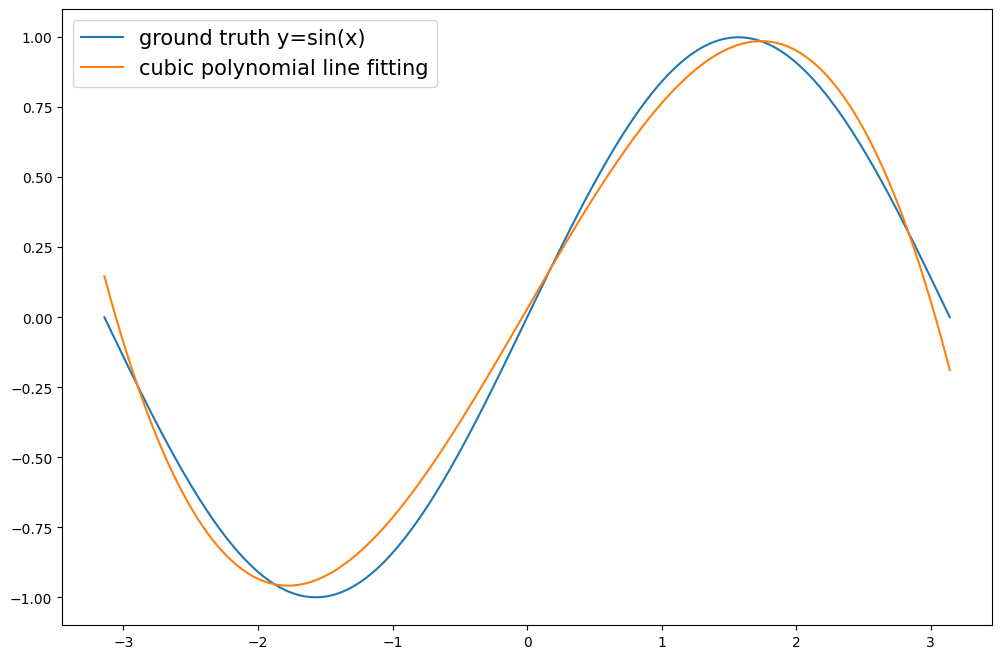

In [65]:
plt.subplots(figsize=(12,8))
plt.plot(x.cpu(), y.cpu(), label='ground truth y=sin(x)')
plt.plot(x.cpu(), y_pred.detach().cpu(), label='cubic polynomial line fitting')
plt.legend(fontsize=15)
